# Analyzing replicability of functional connectivity-based multivariate BWAS on the Human Connectome Project dataset

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.model_selection import KFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from joblib import Parallel, delayed
from mlxtend.evaluate import permutation_test
sns.set(rc={"figure.figsize":(4, 2)})
sns.set_style("whitegrid")

## Load HCP data

We load functional network matrices (netmats) from the HCP1200-release, as published on connectomeDB: https://db.humanconnectome.org/
Due to licensoing issues, data is not supplied with the repository, but can be downloaded from the ConnectomeDB.
See [hcp_data/readme.md](hcp_data/readme.md) for more details.

In [2]:
# HCP data can be obtained from the connectomeDB
# data is not part of this repository
subjectIDs = pd.read_csv('hcp_data/subjectIDs.txt', header=None)

netmats_pearson = pd.read_csv('hcp_data/netmats1_correlationZ.txt',
                             sep=' ',
                             header=None)
netmats_pearson['ID'] = subjectIDs[0]
netmats_pearson.set_index('ID', drop=True, inplace=True)


netmats_parcor = pd.read_csv('hcp_data/netmats2_partial-correlation.txt',
                             sep=' ',
                             header=None)
netmats_parcor['ID'] = subjectIDs[0]
netmats_parcor.set_index('ID', drop=True, inplace=True)

behavior = pd.read_csv('hcp_data/hcp1200_behavioral_data.csv')
behavior = behavior.set_index('Subject', drop=True)

# convert age to numeric
age = []
for s in behavior['Age']:
    if s == '36+':
        age.append(36)
    else:
        split = s.split(sep='-')
        age.append(np.mean((float(split[0]), float(split[1]))))

behavior['age'] = age
behavior

,Release,Acquisition,Gender,Age,3T_Full_MR_Compl,T1_Count,T2_Count,3T_RS-fMRI_Count,3T_RS-fMRI_PctCompl,3T_Full_Task_fMRI,...,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final,age
Subject,,,,,,,,,,,,,,,,,,,,,
100004,S900,Q06,M,22-25,False,0,0,0,0.0,False,...,101.12,86.45,2.0,45.9,107.17,105.31,1.80,0.0,1.80,23.5
100206,S900,Q11,M,26-30,True,1,1,4,100.0,True,...,108.79,97.19,1.0,49.7,72.63,72.03,1.84,0.0,1.84,28.0
100307,Q1,Q01,F,26-30,True,1,1,4,100.0,True,...,101.12,86.45,0.0,38.6,71.69,71.76,1.76,0.0,1.76,28.0
100408,Q3,Q03,M,31-35,True,1,1,4,100.0,True,...,108.79,98.04,2.0,52.6,114.01,113.59,1.76,2.0,1.68,33.0
100610,S900,Q08,M,26-30,True,2,1,4,100.0,True,...,122.25,110.45,0.0,38.6,84.84,85.31,1.92,1.0,1.88,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992774,Q2,Q02,M,31-35,True,2,2,4,100.0,True,...,122.25,111.41,4.0,50.1,107.17,103.55,1.76,0.0,1.76,33.0
993675,S900,Q09,F,26-30,True,2,2,4,100.0,True,...,122.25,110.45,0.0,38.6,84.07,84.25,1.80,1.0,1.76,28.0
994273,S500,Q06,M,26-30,True,1,1,4,100.0,True,...,122.25,111.41,7.0,63.8,110.65,109.73,1.80,1.0,1.76,28.0


# Function to prepare target variable


In [3]:
def create_data(target='CogTotalComp_AgeAdj', feature_data=netmats_parcor):
    # it's a good practice to use pandas for merging, messing up subject order can be painful
    features = feature_data.columns
    df = behavior
    df = df.merge(feature_data, left_index=True, right_index=True, how='left')

    df = df.dropna(subset = [target] + features.values.tolist())
    y = df[target].values
    X = df[features].values
    return X, y

# Function implementing a single bootstrap iteration

We define a workhorse function which:
- randomly samples the discovery and the replication datasets,
- creates cross-validated estimates of predictive performance within the discovery sample
- finalizes the model by fitting it to the whole discovery sample (overfits the discovery but not the replication sample)
- use it to predict the replication sample

In [4]:
def bootstrap_workhorse(X, y, sample_size, model, random_state, shuffle_y=False):

    #create discovery and replication samples by random sampling from the whole dataset (without replacement)

    # if shuffle_y is true, a null model is created bz permuting y
    if shuffle_y:
        rng = np.random.default_rng(random_state)
        y = rng.permutation(y)

    # sample the discovery and replication sets *without replacement* (with replacement introduces spurious dependencies)
    X_discovery, X_replication, y_discovery, y_replication = train_test_split(X, y, train_size=sample_size, test_size=sample_size, shuffle=True, random_state=random_state)

    # standard 10-fold cross-validation
    cv = KFold(10)

    # below we obtain cross-validated predictions in the discovery sample
    predicted_discovery_cv = np.zeros_like(y_discovery)  # here we collect the predictions for each fold
    cor_per_fold = np.zeros(cv.n_splits)  # here we collect the predictive performance in each fold
    i = 0  # just a counter
    for train, test in cv.split(X=X_discovery, y=y_discovery):  # loop to leave one fold out
        model.fit(X=X_discovery[train], y=y_discovery[train]) # fit model to the training set
        predicted_discovery_cv[test] = model.predict(X=X_discovery[test]) # use fitted model to predict teh test set
        cor_per_fold[i] = np.corrcoef(y_discovery[test], predicted_discovery_cv[test])[0,1] # calculate performance on tne test set
        i += 1
    # calculate mean test performance across all folds
    r_disc_cv = np.mean(cor_per_fold)
    # 'finalize' model by training it on the full discovery sample (without cross-validation)
    final_model = model.fit(X=X_discovery, y=y_discovery)
    # obtain predictions with the final model on the discovery sample, note that this model actually overfits this sample.
    # we do this only to demonstrate biased estimates
    predicted_discovery_overfit = final_model.predict(X=X_discovery)
    # here we obtain the biased effect size (r) estimates for demonstrational purposes
    r_disc_overfit = np.corrcoef(predicted_discovery_overfit, y_discovery)[0, 1]

    # We use the final model to predict the replication sample
    # This is correct (no overfitting here), the final model did not see this data during training
    predicted_replication = final_model.predict(X=X_replication)
    # we obtain the out-of-sample prediction performance estimates
    r_rep = np.corrcoef(predicted_replication, y_replication)[0, 1]

    # below we calculate permutation-based p-values for all three effect size estimates (in-sample unbiased, in-sample biased, out-of-sample)
    # (one sided tests, testing for positive correlation)
    p_disc_cv = permutation_test(predicted_discovery_cv, y_discovery, method='approximate', num_rounds=1000, func=lambda x, y: np.corrcoef(x, y)[1][0],seed=random_state)
    p_disc_overfit = permutation_test(predicted_discovery_overfit, y_discovery, method='approximate', num_rounds=1000, func=lambda x, y: np.corrcoef(x, y)[1][0],seed=random_state)
    p_rep = permutation_test(predicted_replication, y_replication, method='approximate', num_rounds=1000, func=lambda x, y: np.corrcoef(x, y)[1][0],seed=random_state)
    # return results
    return r_disc_cv, r_disc_overfit, r_rep, p_disc_cv, p_disc_overfit, p_rep

All set, now we start the analysis.

# Replicability with sample sizes n=50, 100, 200, 300 and max
Here we train a few different models on 100 bootstrap samples.

We aggregate the results of our workhorse function in `n_bootstrap`=100 bootstrap cases (run in parallel).

The whole process is repeated for all sample sizes, fetaure_sets and target variables.

## Here we test all 33 variables, proposed by Marek et al. in their response.

In [35]:
targets = [
#demographics
    'age',
# cognition
    'MMSE_Score',
    'PSQI_Score',
    'PicSeq_AgeAdj',
    'CardSort_AgeAdj',
    'Flanker_AgeAdj',
    'PMAT24_A_CR',
    'CogFluidComp_AgeAdj',
    'CogCrystalComp_AgeAdj',
    'CogEarlyComp_AgeAdj',
    'CogTotalComp_AgeAdj',
    'ReadEng_AgeAdj',
    'PicVocab_AgeAdj',
    'ProcSpeed_AgeAdj',
    'DDisc_AUC_200',
    'VSPLOT_TC',
    'SCPT_SEN',
    'SCPT_SPEC',
# memory
    'IWRD_TOT',
    'ListSort_AgeAdj',
# emotion
    'ER40ANG',
    'ER40FEAR',
    'ER40HAP',
    'ER40NOE',
    'ER40SAD',
    'AngAffect_Unadj',
    'AngHostil_Unadj',
    'AngAggr_Unadj',
    'FearAffect_Unadj',
    'FearSomat_Unadj',
    'FearSomat_Unadj',
    'Sadness_Unadj',
    'LifeSatisf_Unadj',
    'MeanPurp_Unadj',
    'PosAffect_Unadj',
    'Friendship_Unadj',
    'Loneliness_Unadj',
    'PercHostil_Unadj',
    'PercReject_Unadj',
    'EmotSupp_Unadj',
    'InstruSupp_Unadj',
    'PercStress_Unadj',
    'SelfEff_Unadj',
    'Dexterity_AgeAdj',
 # personality
    'NEOFAC_A',
    'NEOFAC_O',
    'NEOFAC_C',
    'NEOFAC_N',
    'NEOFAC_E',
# sensory
    'Noise_Comp',
    'Odor_AgeAdj',
    'PainInterf_Tscore',
    'Taste_AgeAdj',
    'Mars_Final'
]

# Now we fit a simple Ridge regression
(no feature selection, no hyperparameter optimization)
This can be expected to perform better on low samples than SVR.

In [36]:
%%time

random_state = 42
n_bootstrap = 100

features = {
    'netmats_parcor': netmats_parcor#,
    #'netmats_pearson': netmats_pearson
}

models = {
    'ridge': Ridge()
}

# We aggregate all results here:
df = pd.DataFrame(columns=['connectivity','model','target','n','r_discovery_cv','r_discovery_overfit','r_replication','p_discovery_cv','p_discovery_overfit','p_replication'])

for feature_set in features:
    for model in models:
        for target_var in targets:
            for sample_size in ['max']:

                print('*****************************************************************')
                print(feature_set, model, target_var, sample_size)

                X, y = create_data(target=target_var, feature_data=features[feature_set])

                if sample_size=='max':
                    sample_size = int(len(y)/2)

                # create random seeds for each bootstrap iteration for reproducibility
                rng = np.random.default_rng(random_state)
                random_sates = rng.integers(np.iinfo(np.int32).max, size=n_bootstrap)

                # run bootstrap iterations in parallel
                r_discovery_cv, r_discovery_overfit, r_replication, p_discovery_cv, p_discovery_overfit, p_replication = zip(
                    *Parallel(n_jobs=-1)(
                    delayed(bootstrap_workhorse)(X, y, sample_size, models[model], seed) for seed in random_sates))

                tmp_data_frame = pd.DataFrame({
                    'connectivity' : feature_set,
                    'model' : model,
                    'target' : target_var,
                    'n' : sample_size,
                    'r_discovery_cv': r_discovery_cv,
                    'r_discovery_overfit': r_discovery_overfit,
                    'r_replication': r_replication,
                    'p_discovery_cv': p_discovery_cv,
                    'p_discovery_overfit': p_discovery_overfit,
                    'p_replication': p_replication
                })
                #sns.scatterplot(x='r_replication', y='r_discovery_cv', data=tmp_data_frame)
                #plt.ylabel('in-sample (r)')
                #plt.xlabel('out-of-sample (r_pred)')
                #plt.show()
                print(tmp_data_frame.r_discovery_cv.mean(), tmp_data_frame.r_replication.mean())

                for alpha in [0.05, 0.01, 0.005, 0.001]:
                    print('Replicability at alpha =', alpha, ':',
                          (tmp_data_frame.loc[tmp_data_frame['p_discovery_cv']<alpha,'p_replication']<alpha).sum() / (tmp_data_frame['p_discovery_cv']<0.05).sum() * 100, '%')

                df = pd.concat((df, tmp_data_frame))
                df.reset_index(drop=True, inplace=True)
                df.to_csv('res/revised_results_Ridge.csv')

df


*****************************************************************
netmats_parcor ridge age max
0.48020846359551633 0.48967065593640496
Replicability at alpha = 0.05 : 100.0 %
Replicability at alpha = 0.01 : 100.0 %
Replicability at alpha = 0.005 : 100.0 %
Replicability at alpha = 0.001 : 100.0 %
*****************************************************************
netmats_parcor ridge MMSE_Score max
0.11235242553787785 0.12970357972616348
Replicability at alpha = 0.05 : 89.87341772151899 %
Replicability at alpha = 0.01 : 40.50632911392405 %
Replicability at alpha = 0.005 : 25.31645569620253 %
Replicability at alpha = 0.001 : 2.5316455696202533 %
*****************************************************************
netmats_parcor ridge PSQI_Score max
0.14291306988028807 0.14519995923911966
Replicability at alpha = 0.05 : 98.85057471264368 %
Replicability at alpha = 0.01 : 72.41379310344827 %
Replicability at alpha = 0.005 : 47.12643678160919 %
Replicability at alpha = 0.001 : 16.091954022988507

<timed exec>:58: RuntimeWarning: invalid value encountered in long_scalars


0.05015028148085296 0.05477097859212912
Replicability at alpha = 0.05 : 16.666666666666664 %
Replicability at alpha = 0.01 : 0.0 %
Replicability at alpha = 0.005 : 0.0 %
Replicability at alpha = 0.001 : 0.0 %
*****************************************************************
netmats_parcor ridge ER40SAD max
0.033558790476282165 0.043958511763540556
Replicability at alpha = 0.05 : 10.0 %
Replicability at alpha = 0.01 : 0.0 %
Replicability at alpha = 0.005 : 0.0 %
Replicability at alpha = 0.001 : 0.0 %
*****************************************************************
netmats_parcor ridge AngAffect_Unadj max
0.09675041204325668 0.097384559509148
Replicability at alpha = 0.05 : 69.23076923076923 %
Replicability at alpha = 0.01 : 12.307692307692308 %
Replicability at alpha = 0.005 : 1.5384615384615385 %
Replicability at alpha = 0.001 : 0.0 %
*****************************************************************
netmats_parcor ridge AngHostil_Unadj max
0.06336555348912117 0.07505183534895289
Repli

,connectivity,model,target,n,r_discovery_cv,r_discovery_overfit,r_replication,p_discovery_cv,p_discovery_overfit,p_replication
0,netmats_parcor,ridge,age,501,0.480679,1.0,0.51476,0.000999,0.000999,0.000999
1,netmats_parcor,ridge,age,501,0.477272,1.0,0.455021,0.000999,0.000999,0.000999
2,netmats_parcor,ridge,age,501,0.528641,1.0,0.482612,0.000999,0.000999,0.000999
3,netmats_parcor,ridge,age,501,0.488856,1.0,0.502899,0.000999,0.000999,0.000999
4,netmats_parcor,ridge,age,501,0.429166,1.0,0.530274,0.000999,0.000999,0.000999
...,...,...,...,...,...,...,...,...,...,...
5395,netmats_parcor,ridge,Mars_Final,499,0.090619,1.0,0.031658,0.06993,0.000999,0.115884
5396,netmats_parcor,ridge,Mars_Final,499,0.005679,1.0,0.038146,0.565435,0.000999,0.147852
5397,netmats_parcor,ridge,Mars_Final,499,0.017233,1.0,0.057484,0.44955,0.000999,0.106893
5398,netmats_parcor,ridge,Mars_Final,499,0.009701,1.0,0.005276,0.526474,0.000999,0.400599


/tmp/ipykernel_69267/3728022067.py:8: RuntimeWarning: invalid value encountered in long_scalars
  return (x.loc[x['p_discovery_cv']<alpha,'p_replication']<alpha).sum() / (x['p_discovery_cv']<0.05).sum() * 100
/tmp/ipykernel_69267/3728022067.py:12: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  df_plot['r_discovery'] = df[df.connectivity=='netmats_parcor'].groupby('target').mean()['r_discovery_cv']


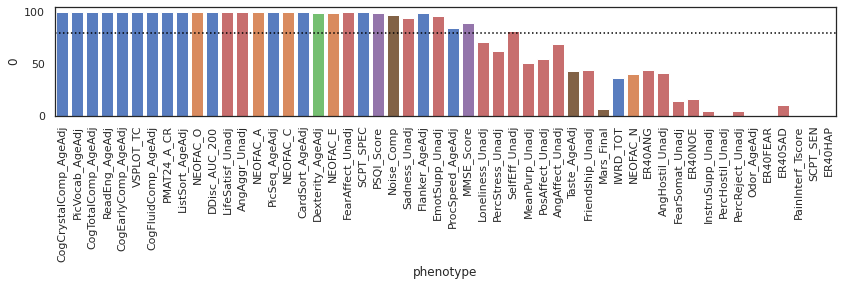

In [163]:
sns.set(rc={"figure.figsize":(14, 2)})
sns.set_style("white")

phenotypes = pd.read_csv('hcp_data/phenotypes-of-interest.csv').iloc[:, 1:]
phenotypes = phenotypes.drop([2,3]) # Age duplicates

def prep(x, alpha=0.05):
    return (x.loc[x['p_discovery_cv']<alpha,'p_replication']<alpha).sum() / (x['p_discovery_cv']<0.05).sum() * 100

df_plot = pd.DataFrame(df[df.connectivity=='netmats_parcor'].groupby('target').apply(prep))

df_plot['r_discovery'] = df[df.connectivity=='netmats_parcor'].groupby('target').mean()['r_discovery_cv']
df_plot = df_plot[df_plot.index!='age']                       
                       
df_plot['category'] = ''
df_plot['phenotype'] = df_plot.index

for i in df_plot.index:
    df_plot.loc[i, 'category'] = phenotypes.loc[phenotypes.columnHeader==i, 'category'].values[0]

                       
df_plot = df_plot.sort_values(by='r_discovery', ascending=False)                      
                       
pal = "muted"
my_colormap = [
              sns.color_palette(pal)[4],
              sns.color_palette(pal)[0], # cognition
              sns.color_palette(pal)[3], # emotion
              sns.color_palette(pal)[2], # dexterity
              sns.color_palette(pal)[1], # big5
              sns.color_palette(pal)[5], # sensory
              sns.color_palette(pal)[6], # ?
              sns.color_palette(pal)[3]]
colors = []
for code in pd.Categorical(df_plot.category).codes:
    colors.append(my_colormap[code])

ax=sns.barplot(data=df_plot, x='phenotype', y=0, palette=colors)
plt.xticks(rotation=90)
ax.axhline(80, color='black', linestyle=':')
plt.savefig('fig/replicability_all_phenotypes.pdf')

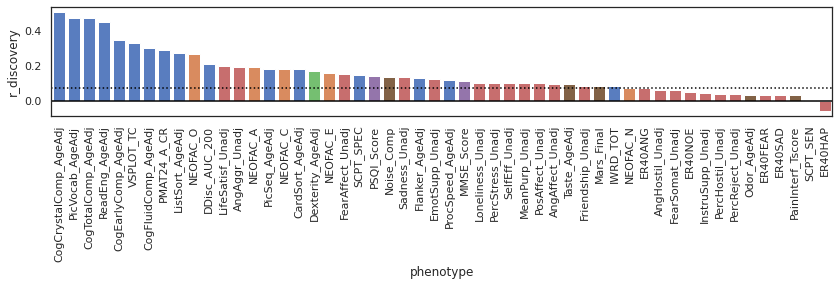

In [164]:
ax=sns.barplot(data=df_plot, x='phenotype', y='r_discovery', palette=colors)
plt.xticks(rotation=90)
ax.axhline(0.074, color='black', linestyle=':') # parametric one-sided significance threshold
ax.axhline(0, color='black')
plt.savefig('fig/r_discovery_all_phenotypes.pdf')

In [ ]:
### df_plot = df_plot.dropna()
len(df_plot), (df_plot[0]>80).sum(), (df_plot[0]<=80).sum(),


In [109]:
29/51

0.5686274509803921

In [155]:
df_plot

,0,r_discovery,category,phenotype
target,,,,
CogCrystalComp_AgeAdj,100.000000,0.509356,Cognition,CogCrystalComp_AgeAdj
PicVocab_AgeAdj,100.000000,0.474802,Cognition,PicVocab_AgeAdj
CogTotalComp_AgeAdj,100.000000,0.472652,Cognition,CogTotalComp_AgeAdj
ReadEng_AgeAdj,100.000000,0.450867,Cognition,ReadEng_AgeAdj
CogEarlyComp_AgeAdj,100.000000,0.350107,Cognition,CogEarlyComp_AgeAdj
VSPLOT_TC,100.000000,0.330419,Cognition,VSPLOT_TC
CogFluidComp_AgeAdj,100.000000,0.304980,Cognition,CogFluidComp_AgeAdj
PMAT24_A_CR,100.000000,0.292243,Cognition,PMAT24_A_CR
ListSort_AgeAdj,100.000000,0.272622,Cognition,ListSort_AgeAdj


In [170]:
tmp = behavior[['CogTotalComp_AgeAdj', 'CogFluidComp_AgeAdj', 'PMAT24_A_CR', 'Flanker_AgeAdj', 'CardSort_AgeAdj', 'PicSeq_AgeAdj']]
tmp.corr()

,CogTotalComp_AgeAdj,CogFluidComp_AgeAdj,PMAT24_A_CR,Flanker_AgeAdj,CardSort_AgeAdj,PicSeq_AgeAdj
CogTotalComp_AgeAdj,1.000000,0.844787,0.529659,0.519260,0.568456,0.515942
CogFluidComp_AgeAdj,0.844787,1.000000,0.356512,0.633329,0.689420,0.614940
PMAT24_A_CR,0.529659,0.356512,1.000000,0.130267,0.221504,0.296054
Flanker_AgeAdj,0.519260,0.633329,0.130267,1.000000,0.518264,0.151930
CardSort_AgeAdj,0.568456,0.689420,0.221504,0.518264,1.000000,0.211827
PicSeq_AgeAdj,0.515942,0.614940,0.296054,0.151930,0.211827,1.000000
